# Problem 1: 实现均值类Z检验代码

In [1]:
from scipy import stats
import numpy as np

## 1.样本生成

In [2]:
def Data_Generate(sample_size,distribution,args):
    '''
    Parameters
    ----------
    sample_size : int
        生成的样本量
    distribution : str
        生成样本的分布
    args : list
        分布的参数

    Returns
    -------
    sample : numpy.ndarray
        抽取的样本
    '''
    # 均匀分布 均值(args[0]+args[1])/2
    if distribution == 'uniform':
        sample = np.random.uniform(args[0],args[1],sample_size)
    # 正态分布 均值args[0]
    elif distribution == 'normal':
        sample = np.random.normal(args[0],args[1],sample_size)
    # 指数分布 均值args[0]
    elif distribution == 'exponential':
        sample = np.random.exponential(args[0],sample_size) 
    # t分布 均值0
    elif distribution == 't':
        sample = np.random.standard_t(args[0],sample_size)  
    # 泊松分布 均值args[0]
    elif distribution == 'poisson':
        sample = np.random.poisson(args[0],sample_size) 
    else:
        raise ValueError('There is no such distribution')
    return sample

## 2.检验函数

In [3]:
class Test:
    def __init__(self,sample,mean):
        self.sample = sample # 数据样本
        self.mean = mean   # 检验均值
        self.N = len(sample) # 样本量
        self.sample_mean = np.mean(sample) # 样本均值
        self.sample_std = np.std(sample) # 样本标准差
        self.sample_sigma = self.sample_std**2
        
    # 计算Z检验统计量
    def Z_value(self):
        self.zvalue = (self.sample_mean - self.mean)/(self.sample_std/np.sqrt(self.N))
    # 计算P值
    def P_value(self,alternative='two_side'):
        self.Z_value()
        if alternative == 'two_side':
            self.pvalue = 2*stats.norm.sf(abs(self.zvalue))
        if alternative == 'larger':
            self.pvalue = 1-stats.norm.sf(self.zvalue)
        if alternative == 'smaller':
            self.pvalue = stats.norm.sf(self.zvalue)
    # 计算置信区间 
    def Confidence_Interval(self,alpha=0.05):
        self.LB = self.sample_mean - 1.96*(self.sample_std/np.sqrt(self.N))
        self.UP = self.sample_mean + 1.96*(self.sample_std/np.sqrt(self.N))
    # 输出摘要   
    def Summary(self,alternative='two_side',alpha=0.05):
        self.P_value(alternative='two_side')
        self.Confidence_Interval(stats.norm.isf(alpha/2))
        return {'样本量':self.N,'样本均值':self.sample_mean,
                '检验均值':self.mean,'P值':self.pvalue,
                '样本方差':self.sample_sigma,'置信水平':alpha,
                '置信上限': self.LB, '置信下限': self.UP}

## 3.模拟结果
模拟了以下几种情况
- 正态样本下的双边检验
- 泊松样本下的单边检验
- 指数分布下的单边检验

样本均抽取200个，以上三个分布符合中心极限定理条件，因此可使用z检验

In [4]:
# 双边检验：正态分布，样本从均值为3的总体中抽取，检验总体均值是否为3
sample = Data_Generate(200,'normal',[3,1])  
test = Test(sample,mean=3)
print(test.Summary())
print('\n双侧检验：正态分布总体均值为3')
print('等于3检验P值',test.pvalue)
# 单边检验：泊松分布，从总体均值为6的分布中抽取200样本，检验是否总体均值大于8       
sample_poi = Data_Generate(200,'poisson',[6])     
test = Test(sample_poi,mean=8)
test.P_value(alternative='larger')
print('\n单侧检验：泊松分布总体均值为6')
print('大于8检验P值',test.pvalue)
test = Test(sample_poi,mean=6.2)
test.P_value(alternative='smaller')
print('小于6.2检验P值',test.pvalue)
# 单边检验：指数分布，从总体均值为6的分布中抽取200样本，检验是否总体均值大于4以及大于8    
sample_exp = Data_Generate(200,'exponential',[6])     
test = Test(sample_exp,mean=4)
test.P_value(alternative='larger')
print('\n单侧检验：指数分布总体均值为6')
print('大于4检验P值',test.pvalue)     
test = Test(sample_exp,mean=8)
test.P_value(alternative='larger')
print('大于8检验P值',test.pvalue)    

{'样本量': 200, '样本均值': 2.926948149796855, '检验均值': 3, 'P值': 0.29495084153984186, '样本方差': 0.973041875544413, '置信水平': 0.05, '置信上限': 2.790236086154113, '置信下限': 3.0636602134395967}

双侧检验：正态分布总体均值为3
等于3检验P值 0.29495084153984186

单侧检验：泊松分布总体均值为6
大于8检验P值 0.0
小于6.2检验P值 0.9999806165433214

单侧检验：指数分布总体均值为6
大于4检验P值 0.9999998514550369
大于8检验P值 9.139698928684048e-06


# Problem 2: 实现均值类thompson  MAB算法，数据的方差和均值均未知

## 1.thompson  MAB算法主体代码

In [5]:
# 载库
%matplotlib inline
import numpy as np
from scipy import stats            
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [6]:
class Sampler:
    '''
    策略生成
    '''
    def __init__(self,payouts,variants,distribution):
        self.payouts = payouts # arm的分布参数
        self.variants = variants # arm对应的序号(索引)
        self.distribution = distribution # 生成样本的分布
        self.variants_rewards = np.zeros(self.variants.shape) # 存储每个arm simulation后对应总的reward
        self.total_reward = 0  # 存储simulation后总的reward 等于 sum(self.variants_rewards)
        self.bayes_params = [] # 存储每轮先验分布的参数
                
    ## 策略生成、更新
    def run(self,agent,n_trials):
        '''
        通过选择此轮的策略，获得相应的回报，并更新先验分布，存储该轮过后先验分布参数
        
        Parameters
        ----------
        agent : ThompsonSampler
            ThompsonSampler实例
        n_trials : int
            进行的策略次数
        '''
        for i in range(n_trials):
            best_variant = agent.choose_variant() # 选择第几个arm，也就是本轮策略
            
            ## 如果arm的分布是二项
            if self.distribution == 'binary':
                agent.reward = np.random.binomial(n=1,p=self.payouts[best_variant]) # 本轮策略产生的回报
                agent.update() # 参数更新
                self.bayes_params.append([[a,b] for a,b in zip(agent.a,agent.b)]) # 存储先验分布参数
            
            ## 如果arm的分布是正态
            if self.distribution == 'normal':
                agent.reward = np.random.normal(self.payouts[best_variant][0],
                                                self.payouts[best_variant][1],
                                                1)
                agent.update()
                self.bayes_params.append([[mu,tau,alpha,lambd] for mu,tau,alpha,lambd in zip(agent.mu,agent.tau,agent.alpha,agent.lambd)])
            
            ## 如果arm的分布是泊松
            if self.distribution == 'poisson':
                agent.reward = np.random.poisson(self.payouts[best_variant],1)
                agent.update()
                self.bayes_params.append([[alpha,beta] for alpha,beta in zip(agent.alpha,agent.beta)])
                
                
            
            self.total_reward += agent.reward # 更新总回报
            self.variants_rewards[best_variant] += agent.reward # 更新本轮arm所对应的回报

        return self.total_reward, self.variants_rewards

**分布选择:** 伯努利、正态、泊松分布，他们对应先验分布分别为

- **伯努利** 样本来自$Bin(1,\theta)$，参数$\theta$的先验为$Beta(a,b)$有后验分布:
$$
\pi(\theta|x) \sim Beta(x+a,1-x+b)
$$

- **正态分布** 样本来自$N(\theta,\sigma^2)$，$\sigma^2$已知，参数$\theta$的先验为$N(\mu,\tau^2)$有后验分布:$$
\pi(\theta|x) \sim N(\frac{\frac{x}{\sigma^2}+ \frac{\mu}{\tau^2}}{\frac{1}{\sigma^2}+\frac{1}{\tau^2}}, \frac{1}{\frac{1}{\sigma^2}+\frac{1}{\tau^2}}) $$ $\theta$已知，$\sigma^2$的先验分布为$IGamma(\alpha,\lambda)$有后验分布: 
$$
\pi(\sigma^2 |x) \sim IGamma(\alpha+\frac{1}{2} ,\lambda + \frac{1}{2} (x-\theta)^2)
$$**Note：**  当$\theta,\sigma^2$均未知，也有对应的共轭先验分布$(\theta,\sigma^2) \sim N-IGamma(\mu_0,\kappa_0,\nu_0,\sigma_0^2)$，但这里借助Gibbs采样的方法，使用上述两个后验分布估计参数即可

- **泊松分布** 样本来自$Poi(\lambda)$, $\lambda$先验为$Gamma(\alpha,\beta)$
$$\pi(\lambda|x) \sim Gamma ( x+\alpha,1+\beta)$$



In [7]:
class ThompsonSampler(Sampler):
    '''
    Thompson实现，主要实现：给定先验分布、策略选择、参数更新
    '''
    def __init__(self,sampler):
        self.sampler = sampler # Sampler
        self.theta = None # 初始化均值参数
        self.best_variant = None # 初始化最好的arm序列
        self.reward = 0 # 初始化回报
        self.thetas = [] # 存储每轮均值
        
        # 伯努利分布
        if self.sampler.distribution == 'binary':
            self.a = np.ones(len(sampler.variants)) # 初始化beta分布参数a
            self.b = np.ones(len(sampler.variants)) # 初始化beta分布参数b
            
            
        # 正态分布           
        if self.sampler.distribution == 'normal':
            self.mu = np.zeros(len(sampler.variants)) # 初始化先验正态分布参数mu
            self.tau = np.ones(len(sampler.variants))
            self.alpha = np.ones(len(sampler.variants)) # 初始化先验Gamma分布参数alpha
            self.lambd = np.ones(len(sampler.variants))
        
        # 泊松分布
        if self.sampler.distribution == 'poisson':
            self.alpha = np.ones(len(sampler.variants))+1
            self.beta = np.ones(len(sampler.variants))
    
    ## 策略选择  
    def choose_variant(self):
        '''
        用于在不同分布下进行策略选择，也就是选择theta值最高的arm
        '''
        if self.sampler.distribution == 'binary':
            self.theta = np.random.beta(self.a, self.b)

        if self.sampler.distribution == 'normal':
            self.theta = np.random.normal(self.mu,self.tau)
            self.sigma = 1/np.random.gamma(self.alpha,1/self.lambd)
 
        if self.sampler.distribution == 'poisson':
            self.theta = np.random.gamma(self.alpha,1/self.beta)
            
        self.best_variant = self.sampler.variants[np.argmax(self.theta)]
        self.thetas.append(max(self.theta))
        return self.best_variant
        
    ## 先验参数更新
    def update(self):
        '''
        更新每轮策略后的后验参数作为下次策略的先验        
        '''
        if self.sampler.distribution == 'binary':
            self.a[self.best_variant] += self.reward
            self.b[self.best_variant] += (1 - self.reward)
        
        if self.sampler.distribution == 'normal':
            # 这里总体的均值和方差均未知，参考Gibbs采样，当做某参数已知时更新另一个参数
            mu = self.reward / self.sigma[self.best_variant]+self.mu[self.best_variant]/self.tau[self.best_variant]
            self.mu[self.best_variant] = mu/(1/self.sigma[self.best_variant]+1/self.tau[self.best_variant])
            self.tau[self.best_variant] = 1/(1/self.sigma[self.best_variant]+1/self.tau[self.best_variant])  
            self.alpha[self.best_variant] = self.alpha[self.best_variant]+1/2
            self.lambd[self.best_variant] = self.lambd[self.best_variant] + ((self.reward-self.theta[self.best_variant])**2)/2
            
        if self.sampler.distribution == 'poisson':
            self.alpha[self.best_variant] += self.reward
            self.beta[self.best_variant] += 1


## 2. 不同分布下simulation结果与分析

In [8]:
def plot_variants(sampler, thompsonsampler,iter_num,distribution, save_to=None):
    '''
    用于展示iter_num轮的后验分布的pdf

    Parameters
    ----------
    sampler : Sampler
        Sampler实例，策略模拟器
    iter_num : int
        第iter_num次策略(迭代)
    distribution : str
        样本(arm)原始分布
    save_to : TYPE, optional
        The default is None.
    '''
    
    iteration = sampler.bayes_params[iter_num] # 选择第iter_num的后验参数
    plt.style.use('ggplot')
    color = iter(plt.cm.rainbow(np.linspace(0, 1, len(iteration))))
    
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    if distribution == 'binary':
        x = np.linspace(0, 1, 5000)
        for i, (a, b) in enumerate(iteration): # 对arm进行循环，每个arm最终的后验分布均展示
            c = next(color)
            y = stats.beta.pdf(x, a=a, b=b) # 后验分布pdf
            plt.plot(x, y, color=c, lw=2.1, label=f'Variant {i}') 
        plt.legend()
        plt.title(rf'Prior Beta distribution of $\theta$, iteration number {iter_num}')
        
    elif distribution == 'normal':
        x = np.linspace(-1, 5, 5000)
        for i, (mu, tau,_,_) in enumerate(iteration):
            c = next(color)
            y = stats.norm.pdf(x,loc=mu, scale=tau)
            plt.plot(x, y, color=c, lw=2.1, label=f'Variant {i}')
            
        plt.legend()
        plt.title(rf'Prior Normal distribution of $\theta$, iteration number {iter_num}')   
        
    
    elif  distribution == 'poisson':
        x = np.linspace(0, 6, 5000)
        for i,(alpha,beta) in enumerate(iteration):
            c = next(color)
            y = stats.gamma.pdf(x,a=alpha,scale=1/beta) # 注意scipy与numpy中的差别
            plt.plot(x,y,color=c, lw=2.1, label=f'Variant {i}')
        plt.legend()
        plt.title(rf'Prior Gamma distribution of $\theta$, iteration number {iter_num}')              
    
    
    plt.subplot(122)
    plt.plot(range(len(thompsonsampler.thetas)),thompsonsampler.thetas)
    plt.title(r'Each iteration of $\theta$')
    plt.xlabel('Number of iteration')
    
    
    if save_to is not None:
        plt.savefig(distribution+f'_{iter_num}.png', format='png')
    else:
        plt.show()
        


### 2.1 伯努利分布

(767, array([ 17.,   1., 748.,   1.,   0.,   0.]))


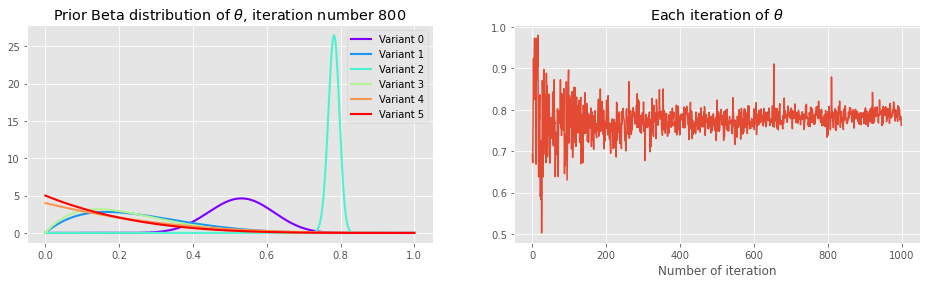

In [9]:
pay = np.array([0.55, 0.04, 0.80, 0.09, 0.22, 0.012]) # 给定arm的分布参数 0.55指第一个arm服从p=0.55的伯努利分布
variants = np.arange(len(pay)) 
np.random.seed(2021)
sampler = Sampler(payouts=pay, variants=variants,distribution='binary')
thompsonsampler = ThompsonSampler(sampler) 
ans = sampler.run(agent=thompsonsampler, n_trials=1000) # 训练
print(ans) # 返回总回报与每个arm的回报
plot_variants(sampler, thompsonsampler,iter_num=800,distribution='binary')

(400, array([ 17.,   7.,   8.,  60.,  10., 298.]))


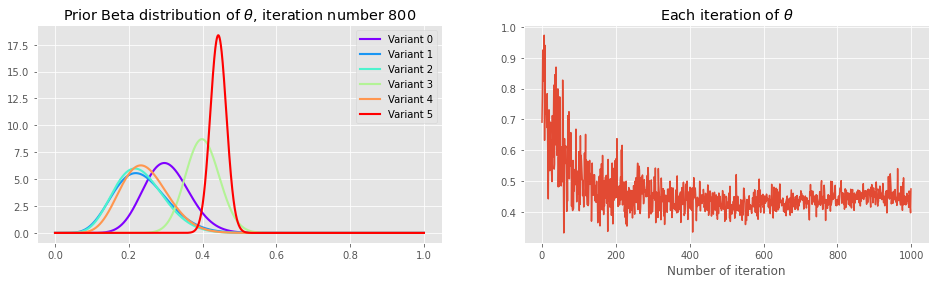

In [10]:
pay = np.array([0.33, 0.24, 0.20, 0.40, 0.22, 0.45]) 
variants = np.arange(len(pay)) 
np.random.seed(2021)
sampler = Sampler(payouts=pay, variants=variants,distribution='binary')
thompsonsampler = ThompsonSampler(sampler) 
ans = sampler.run(agent=thompsonsampler, n_trials=1000) # 训练
print(ans) # 返回总回报与每个arm的回报
plot_variants(sampler, thompsonsampler,iter_num=800,distribution='binary')

### 2.2 结果分析

- **第一种情况：最大概率老虎机与其余老虎机概率相差较大**  实验(策略)次数:1000次，总回报: 762

|     老虎机      |    Variant0     |   Variant1     |   Variant2     |    Variant3    |  Variant4   |Variant5     |
| :-----------: | :---------: | :-----------: | :---------: | :---------: | :-------: | :-------: |
|    真实概率    |    0.55    |   0.04  | 0.8  | 0.09    |   0.22   |   0.012  |
|   模拟数量    |   17    |    1    |    748    |  1   | 0   | 0|

第一种情况，拥有最大概率获得1个回报的老虎机为Variant2，概率为0.8，其余老虎机获得回报概率较小，从表中与图1左图来看，模型**识别能力较强**，平均回报为0.767接近0.8，在图1右图可见，在迭代200次之后趋于稳定。



- **第二种情况：概率最大两个老虎机概率差不多** 实验(策略)次数:1000次，总回报: 399

|     老虎机      |    Variant0     |   Variant1     |   Variant2     |    Variant3    |  Variant4   |Variant5     |
| :-----------: | :---------: | :-----------: | :---------: | :---------: | :-------: | :-------: |
|    真实概率    |    0.33    |   0.24  | 0.20  | 0.40    |   0.22   |   0.45  |
|   模拟数量    |   17    |    7    |    8    |  60   | 10   | 298|

第二种情况，拥有最大概率获得1个回报的老虎机为Variant5，概率为0.45；Variant3概率与之相近，概率为0.40，其余老虎机获得回报概率较小。从表2与图2左图，模型此时识别能力较弱，会有97次的回报发生在Variant3，平均回报为0.4，在图1右图可见其收敛速度也比较慢，在迭代400次之后趋于稳定。





### 2.3 正态分布

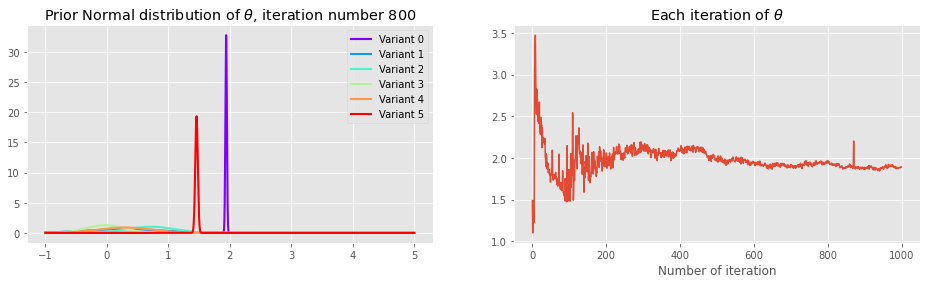

(array([1835.82649923]), array([ 1.70893770e+03,  1.80530102e+00,  1.16278299e+00, -4.65619687e-02,
        1.15994736e+00,  1.22807328e+02]))


In [11]:
pay = np.array([[2,3], [0.5,1], [0.3,1], [0.7,1], [0.6,1], [1.2,1]])
variants = np.arange(len(pay))
np.random.seed(2021)
sampler = Sampler(payouts=pay, variants=variants,distribution='normal')
thompsonsampler = ThompsonSampler(sampler)
ans = sampler.run(agent=thompsonsampler, n_trials=1000)
plot_variants(sampler, thompsonsampler,iter_num=800,distribution='normal')
print(ans) # 返回总回报与每个arm的回报

In [12]:
pay = np.array([[2,3], [0.5,1], [0.3,1], [0.7,1], [0.6,1], [1.2,1]])
variants = np.arange(len(pay))
mus=[]
for i in tqdm(range(200)):
    np.random.seed(i)
    sampler = Sampler(payouts=pay, variants=variants,distribution='normal')
    thompsonsampler = ThompsonSampler(sampler)
    sampler.run(agent=thompsonsampler, n_trials=1000)
    mus.append(np.argmax(thompsonsampler.mu))

mus = pd.Series(mus)
print(mus.groupby(mus).count())

100%|██████████| 200/200 [00:16<00:00, 11.85it/s]

0    143
1      1
2      1
3      2
5     53
dtype: int64


### 2.4 结果分析

实验(策略)次数:1000次，总回报: 1708

|     老虎机      |    Variant0     |   Variant1     |   Variant2     |    Variant3    |  Variant4   |Variant5     |
| :-----------: | :---------: | :-----------: | :---------: | :---------: | :-------: | :-------: |
|    真实(总体)均值    |    2    |   0.5  | 0.3  | 0.7    |   0.6   |   1.2  |
|   总体方差    |   3    |    1    |    1    |  1   | 1   | 1|
|   模拟回报    |   1708   |    1.80    |    1.16    |  -0.04   | 1.15   | 122|

如果只有Variant0，那么我们预期的回报会在2000左右，在正态分布下，会有一些回报发生在Variant5，其中一个**重要的原因**是这里Variant0的方差为3其余Variant方差较小，**缩小方差，结果会更稳定**。当然造成这个问题的**根本原因**应该是$\theta$的先验分布是正态分布，正态分布在方差一定的情况下较其他分布容易产生极大极小的值。

根据上述结果的启发，重复实验以上代码200轮，每次更换随机种子并统计每轮第1000次迭代最大的抽样均值来自哪个Variant，结果如下表所示：

|     老虎机      |    Variant0     |   Variant1     |   Variant2     |    Variant3    |  Variant4   |Variant5     |
| :-----------: | :---------: | :-----------: | :---------: | :---------: | :-------: | :-------: |
|    出现次数   |    143    |   1  | 1  | 2    |   0   |   53  |

同样验证以上结论，如果将Variant0方差降至1则更多回报将发生在Variant0

### 2.5 泊松分布

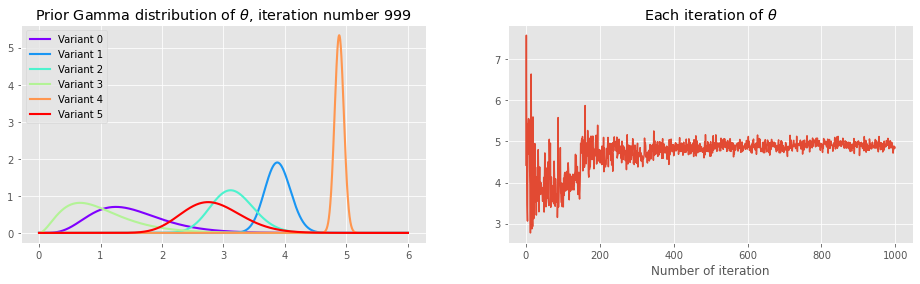

(array([4718]), array([4.000e+00, 3.400e+02, 8.000e+01, 1.000e+00, 4.261e+03, 3.200e+01]))


In [13]:
pay = np.array([2, 4, 3, 1, 5, 2])
variants = np.arange(len(pay))
np.random.seed(2021)
sampler = Sampler(payouts=pay, variants=variants,distribution='poisson')
thompsonsampler = ThompsonSampler(sampler)
ans = sampler.run(agent=thompsonsampler, n_trials=1000)
plot_variants(sampler, thompsonsampler,iter_num=999,distribution='poisson')
print(ans)

### 2.6 结果分析

实验(策略)次数:1000次，总回报: 4718

|     老虎机      |    Variant0     |   Variant1     |   Variant2     |    Variant3    |  Variant4   |Variant5     |
| :-----------: | :---------: | :-----------: | :---------: | :---------: | :-------: | :-------: |
|    真实(总体)均值    |    2    |   4  | 3  | 1    |   5   |   2  |
|   模拟回报    |   4    |    340    |    80    |  1   | 4261   | 32|

如果只有Variant4回报应该为5000，而此时回报达到了4718，远高于仅有Variant1所能产生的4000，效果与之前两个分布类似
